In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.TD_NN import TemporalDifferenceNN
from utils.NeuralNet import TwoHiddenLayerNN

from utils import Benchmarking

# seed = 42
# torch.manual_seed(seed)

In [2]:
housedata = torch.tensor(np.loadtxt('data\\readyhousedata.txt', delimiter=','), dtype=torch.float32)

X = housedata[:, :-1]
y = housedata[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Parameters for TD
num_samples, num_features = X_train.shape
num_samples_test, num_features_test = X_test.shape
P = torch.ones((num_samples, num_samples)) / num_samples # Equal probability to move to any state

identity = lambda x : x

In [4]:
num_samples

404

In [5]:
# Initialise classes
td_sgd = TemporalDifferenceNN(
    optimizer='sgd',
    input_size=num_features,
    learning_rate=0.001,
    epsilon=1e-7,
    n_iter=1e6,
    P=P,
)

td_adam = TemporalDifferenceNN(
    optimizer='adam',
    input_size=num_features,
    learning_rate=0.01,
    epsilon=1e-7,
    n_iter=1e6,
    P=P,
    betas=(0.85, 0.999),
)

nn_sgd = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='sgd',
    learning_rate=0.001,
)

nn_adam = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='adam',
    learning_rate=0.001,
)

In [6]:
iter = 10
# Define noise standard deviation
noise_std = 0.1

# Initialize tensors to store predictions over iterations
Y_pred_td_sgd = torch.zeros(num_samples_test, iter)
Y_pred_td_adam = torch.zeros(num_samples_test, iter)
Y_pred_nn_sgd = torch.zeros(num_samples_test, iter)
Y_pred_nn_adam = torch.zeros(num_samples_test, iter)

Y_pred_td_sgd_noisy = torch.zeros(num_samples_test, iter)
Y_pred_td_adam_noisy = torch.zeros(num_samples_test, iter)
Y_pred_nn_sgd_noisy = torch.zeros(num_samples_test, iter)
Y_pred_nn_adam_noisy = torch.zeros(num_samples_test, iter)

# Add Gaussian noise to the test set
for i in range(iter):
    # Reset model weights
    td_sgd.reset()
    td_adam.reset()
    nn_sgd.reset()
    nn_adam.reset()

    # Train the TD models
    td_sgd.fit(X_train, y_train)
    td_adam.fit(X_train, y_train)

    # Train the NN models
    nn_sgd.fit(X_train, y_train, epochs=1600)
    nn_adam.fit(X_train, y_train, epochs=1600)

    # Generate noise
    X_test_noisy = X_test + torch.randn(X_test.shape) * noise_std
    
    # TD predictions on original and noisy test sets
    Y_pred_td_sgd[:, i] = td_sgd.predict(X_test).squeeze()
    Y_pred_td_sgd_noisy[:, i] = td_sgd.predict(X_test_noisy).squeeze()
    Y_pred_td_adam[:, i] = td_adam.predict(X_test).squeeze()
    Y_pred_td_adam_noisy[:, i] = td_adam.predict(X_test_noisy).squeeze()

    # NN predictions on original and noisy test sets
    Y_pred_nn_sgd[:, i] = nn_sgd.predict(X_test).squeeze()
    Y_pred_nn_sgd_noisy[:, i] = nn_sgd.predict(X_test_noisy).squeeze()
    Y_pred_nn_adam[:, i] = nn_adam.predict(X_test).squeeze()
    Y_pred_nn_adam_noisy[:, i] = nn_adam.predict(X_test_noisy).squeeze()


Ending optimization early at iteration 7016
Ending optimization early at iteration 8897
Ending optimization early at iteration 43209
Ending optimization early at iteration 12507
Ending optimization early at iteration 7956
Ending optimization early at iteration 1316
Ending optimization early at iteration 21521
Ending optimization early at iteration 2638
Ending optimization early at iteration 1835
Ending optimization early at iteration 19583
Ending optimization early at iteration 4210
Ending optimization early at iteration 25413
Ending optimization early at iteration 6301
Ending optimization early at iteration 12205
Ending optimization early at iteration 12152
Ending optimization early at iteration 5630
Ending optimization early at iteration 5788
Ending optimization early at iteration 6216
Ending optimization early at iteration 3543
Ending optimization early at iteration 5514


In [7]:
change_td_sgd = Benchmarking.mean_absolute_diff(Y_pred_td_sgd, Y_pred_td_sgd_noisy)
change_td_adam = Benchmarking.mean_absolute_diff(Y_pred_td_adam, Y_pred_td_adam_noisy)
change_nn_sgd = Benchmarking.mean_absolute_diff(Y_pred_nn_sgd, Y_pred_nn_sgd_noisy)
change_nn_adam = Benchmarking.mean_absolute_diff(Y_pred_nn_adam, Y_pred_nn_adam_noisy)

# Print the results
print(f"Average change for TD-SGD: {torch.mean(change_td_sgd)} ± {torch.std(change_td_sgd)}")
print(f"Average change for TD-Adam: {torch.mean(change_td_adam)} ± {torch.std(change_td_adam)}")
print(f"Average change for L2-SGD: {torch.mean(change_nn_sgd)} ± {torch.std(change_nn_sgd)}")
print(f"Average change for L2-Adam: {torch.mean(change_nn_adam)} ± {torch.std(change_nn_adam)}")

Average change for TD-SGD: 2.7417657375335693 ± 0.6307973861694336
Average change for TD-Adam: 3.975468397140503 ± 0.8426011204719543
Average change for L2-SGD: 3.2978248596191406 ± 0.39082908630371094
Average change for L2-Adam: 4.4949116706848145 ± 0.4105164110660553


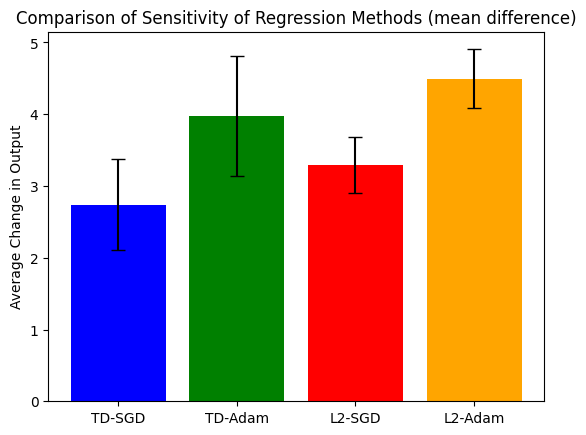

In [8]:
# Plot the changes in predictions
Benchmarking.plot_noise_diff(
    td_sgd=change_td_sgd, 
    td_adam=change_td_adam, 
    nn_sgd=change_nn_sgd, 
    nn_adam=change_nn_adam,
    )

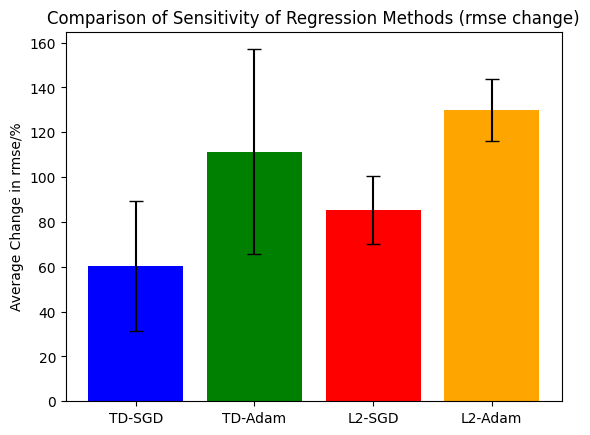

In [9]:
rmse_change_td_sgd =  Benchmarking.mean_rmse_change(y_test, Y_pred_td_sgd, Y_pred_td_sgd_noisy)
rmse_change_td_adam = Benchmarking.mean_rmse_change(y_test, Y_pred_td_adam, Y_pred_td_adam_noisy)
rmse_change_nn_sgd =  Benchmarking.mean_rmse_change(y_test, Y_pred_nn_sgd, Y_pred_nn_sgd_noisy)
rmse_change_nn_adam = Benchmarking.mean_rmse_change(y_test, Y_pred_nn_adam, Y_pred_nn_adam_noisy)

# Plot the changes in predictions
Benchmarking.plot_rmse_diff(
    td_sgd=rmse_change_td_sgd, 
    td_adam=rmse_change_td_adam, 
    nn_sgd=rmse_change_nn_sgd, 
    nn_adam=rmse_change_nn_adam,
    )